In [1]:
# packages and settings #

# Libraries Needed for data manipulation#
import numpy as np
import pandas as pd

# Library needed to change working directories within the code 
import os

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# customize your palette with hex codes below
palette = ['#fb9da0', '#33bebc', '#ffa91f', 
                  '#a73365', '#98c992', '#a7765d', 
                  '#ff4733', '#a3bcf9', '#883e8e',
                  '#266dd3'
                 ]
sns.set_theme(style="ticks") # change here if needed
sns.set_palette(sns.color_palette(palette))
sns.set_context("talk") # change here if needed

# Library for statistics and linear regression
from scipy import stats

# Library for latex 
from IPython.display import Latex

In [2]:
### Diffusion Coefficient Calculation for SPT ##

#############
# Variables #
#############

# fileName = the name of your file as a string with the .csv ending
# sample_id = sample identifier 
# min_lifetime = minimum lifetime of a track in frames
# time_per_frame = time per frame in seconds
# min_disp = minimum displacement in microns; tracks with a total displacement over this value will not be filtered out

############
# Outputs #
###########

# "[sample_id]_Filtered" csv: Tracks filtered by minimum lifetime
# Dataframe containing the same tracks as stored in the csv, with additional information:
# Lifetime in frames and seconds, time averaged MSD, D calculated from TA-MSD, and a list of MSDs calculated with increasing time lags
# (beginning at time lag = time per frame in seconds)
#    ---> The Dataframe is returned by the function; ie, when you run this function, you can set output = focitracker()
#         and this dataframe is stored in the output variable
# "[sample_id]_diffusion_coef" csv: Same information as in the Dataframe

def focitracker(fileName, sample_id, min_lifetime, time_per_frame, min_disp = None):
    fociData = pd.read_csv(fileName)
    ## Comment out if you already filter your TrackMate files
    #fociData = fociData[3:]
    fociData = fociData.reset_index(drop=True)
    
    Ds = pd.DataFrame(columns=['TRACK_ID', 'FRAME', 'TrackObjects_Lifetime', 'POSITION_X', 'POSITION_Y'])
    data_by_foci = fociData.groupby("TRACK_ID")
    for track_id, cur_foci in data_by_foci:
        cur_foci['FRAME'] = cur_foci['FRAME'].convert_dtypes()
        cur_foci["FRAME"] = pd.to_numeric(cur_foci["FRAME"])
        cur_foci = cur_foci.sort_values(by='FRAME')
        cur_foci = cur_foci.reset_index(drop=True)
        cur_foci['TrackObjects_Lifetime'] = np.arange(1, len(cur_foci) + 1)
        new_entries = pd.DataFrame({
        'TRACK_ID': track_id,
        'FRAME': cur_foci['FRAME'],  
        'TrackObjects_Lifetime': cur_foci['TrackObjects_Lifetime'],
        'POSITION_X': cur_foci["POSITION_X"], 
        'POSITION_Y': cur_foci["POSITION_Y"]  
        }) #each dataframe contains all rows pertaining to the current foci
        Ds = pd.concat([Ds, new_entries], ignore_index=True)
    fociData = Ds
        
    foci_to_keep = []
    for i in range(len(fociData)): #i is the index for all rows in the dataset
        if fociData["TrackObjects_Lifetime"][i] == min_lifetime and pd.notna(fociData["TRACK_ID"][i])==True:
            foci_to_keep.append(fociData["TRACK_ID"][i])
    fociData_filtered = fociData[fociData["TRACK_ID"].isin(foci_to_keep)]
    fileName = fileName.split('.')[0]
    fociData_filtered.to_csv(fileName + '_filtered' + '.csv')
    
    data_by_foci = fociData_filtered.groupby("TRACK_ID")
    Ds = np.zeros((len(foci_to_keep), 7), dtype=object ) # sets up a blank array with 7 columns; #of rows = #of foci
    i= 0
   
    for group in foci_to_keep:
        cur_foci = data_by_foci.get_group(group)
        Ds[i,0] = group # foci identifier
    
        lifetime_f = len(cur_foci["TrackObjects_Lifetime"])
        Ds[i,1] = lifetime_f # lifetime of the track in frames
    
        lifetime_s = len(cur_foci["TrackObjects_Lifetime"])* time_per_frame
        Ds[i,2] = lifetime_s # lifetime of the track in seconds
        
        x_positions = cur_foci["POSITION_X"].tolist()
        y_positions = cur_foci["POSITION_Y"].tolist()
        num_positions = len(x_positions)
        MSDs = np.zeros(num_positions)
        for time_lag in range(1,num_positions): #the time lag progressively increases
            displacements_squared = []
            for j in range(num_positions - time_lag):#at the smallest time lag, MSD is calculated betweeen each pos. At the largest time lag, MSD is calculated between the final and the initial pos.
                displacement_x = (x_positions[j+time_lag] - x_positions[j])
                displacement_y = (y_positions[j+time_lag] - y_positions[j])
                displacements_squared.append(displacement_x**2 + displacement_y**2)
                if time_lag == num_positions-1:
                    Ds[i,3] = np.sqrt(displacement_x**2 + displacement_y**2) #total displacement
            MSDs[time_lag] = np.mean(displacements_squared) #The MSD is time averaged differently based on the time lag.
            
        Ds[i,4] = MSDs[min_lifetime-1] #Take the time averaged MSD for the particular time lag that corresponds to the min lifetime. The index is one less than min_lifetime
     #Diffusion coefficient (um^2/s)
        Ds[i,5] = MSDs[min_lifetime-1]/(4*(min_lifetime*time_per_frame)) #Comes from D = MSD/2*n*t where n is the number of dims (2 for x,y), and t is min lifetime of the track
        Ds[i,6] = MSDs.tolist()

        i += 1

    Ds_dataframe = pd.DataFrame(Ds, columns = ['foci_n', 
                                               'lifetime_f', 
                                               'lifetime_s',
                                               'total_disp',
                                               'TA-MSD',
                                               'D (from TA-MSD)',
                                               'msd_per_time_unit'])
    if min_disp != None:
        Ds_dataframe = Ds_dataframe[Ds_dataframe['total_disp'] >= min_disp].reset_index(drop=True)
    Ds_dataframe['sample_id'] = sample_id
    Ds_dataframe.to_csv(fileName + "_diffusion_coef.csv")
    
    return Ds_dataframe

In [6]:
def import_data(dir, folder, sample_id, min_lifetime, time_per_frame, min_disp):
    l = []
    os.chdir(dir + folder)
    for dirpath, dirname, filenames in os.walk("."):
        print(f'Found directory:'+dir+folder)
        for file_name in filenames:
            if not file_name.endswith(".csv"):
                continue
            full_path = os.path.join(dirpath, file_name)
            print("Analyzing: ", file_name)
            result = focitracker(file_name, sample_id, min_lifetime, time_per_frame, min_disp)
            l.append(result)
            
    dataframe = pd.concat(l, ignore_index=True)
    return dataframe

In [9]:
### Graphing of Diffusion Coefficients and MSD Curves##

#############
# Variables #
#############

# dataset = the name of your Diffusion coefficient dataframe (output of focitracker function above)
# sample_id = sample identifier (what would you like to call it?) 
# min_lifetime = minimum lifetime of a track in frames (lowest lifetime possible = 1 frame)
# time_per_frame = time per frame in seconds (your exposure time/ collection rate on the microscope)
# r2_cutoff = the R^2 value of the linear fit of each MSD curve above or equal to which your MSD curve will be kept (default value = 0.7)
# rerun = Make this value "True" if you have converted the dataset (focitracker output) to a csv and then back to a dataframe

###########
# Outputs #
###########

# MSD vs Time plot and LOG-LOG plot, unfiltered by R^2 fit to linear portion on log-log plot
# MSD vs Time plot and LOG-LOG plot, filtered by R^2 fit to linear portion on log-log plot
# Distribution of D (um2/s), calculated from slope of the linear portion of the log-log MSD curve (only from MSDs filtered by R^2)
# data_filtered_final csv file: Contains information for all tracks that have been filtered by R^2 and lifetime (MSDs, Ds, fit information, sample id, and more)

def graphs(dataset, sample_id, min_lifetime, time_per_frame, r2_cutoff=0.7):
    
    #Plot the MSD curves for each track, in a subplot: Left is normal scale, right is log-log
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].set_title('MSD of '+ sample_id + ' (unfiltered)')
    for i in range(dataset.shape[0]):
        list_of_values = dataset['msd_per_time_unit'][i]
        axs[0].plot(np.arange(time_per_frame,
                              dataset['lifetime_s'][i] - 1e-9, 
                              time_per_frame), 
                    list_of_values[1:])
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel(r"MSD ($\mu m^2$)")
    
    for i in range(dataset.shape[0]):
        lagtimes = np.arange(time_per_frame,
                             dataset['lifetime_s'][i]+time_per_frame, 
                             time_per_frame)
        list_of_values = dataset['msd_per_time_unit'][i]
        axs[1].loglog(np.arange(time_per_frame,dataset['lifetime_s'][i] - 1e-9, 
                                time_per_frame), 
                      list_of_values[1:])
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel(r"MSD ($\mu m^2$)")
    axs[1].set_title('Log-Log Plot of MSD')
    
    plt.tight_layout()
    plt.savefig('MSD_unfiltered_plot_'+sample_id+'.svg')
    plt.show()
    

    Ds_recalculated = np.zeros((dataset.shape[0], 7), dtype=object )
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i in range(dataset.shape[0]):
        msd = dataset['msd_per_time_unit'][i]
        start_time = time_per_frame
        start_index = int(start_time/time_per_frame)-1
        end_time = time_per_frame*min_lifetime
        end_index = int(end_time/time_per_frame)
        linear_model = stats.linregress(lagtimes[start_index:end_index], 
                                  msd[start_index:end_index])
        slope = linear_model.slope
        r_2 = (linear_model.rvalue)**2
        D = slope /(2*2) #since the slope = 2*dim*D, D = slope/2*2 (for 2 dims)
        if r_2 >= r2_cutoff:
            axs[0].plot(np.arange(time_per_frame,
                                  dataset['lifetime_s'][i] - 1e-9, 
                                  time_per_frame), 
                        msd[1:])
    
    axs[0].set_xlabel(r"Time lag, $\tau$ (s)")
    axs[0].set_ylabel(r"MSD ($\mu m^2$)")
    
    for i in range(dataset.shape[0]):
        msd = dataset['msd_per_time_unit'][i]
        start_time = time_per_frame
        start_index = int(start_time/time_per_frame)-1
        end_time = time_per_frame*min_lifetime
        end_index = int(end_time/time_per_frame)
        linear_model = stats.linregress(lagtimes[start_index:end_index], 
                                  msd[start_index:end_index])
        slope = linear_model.slope
        r_2 = (linear_model.rvalue)**2
        D = slope /(2*2) #since the slope = 2*dim*D, D = slope/2*2 (for 2 dims)
        if r_2 >= r2_cutoff:
            Ds_recalculated[i,0] = dataset['foci_n'][i]
            Ds_recalculated[i,1] = dataset['lifetime_f'][i]
            Ds_recalculated[i,2] = dataset['lifetime_s'][i]
            Ds_recalculated[i,3] = msd
            Ds_recalculated[i,4] = D
            Ds_recalculated[i,5] = r_2
            Ds_recalculated[i,6] = linear_model.intercept
            axs[1].loglog(np.arange(time_per_frame,
                                    dataset['lifetime_s'][i] - 1e-9, 
                                    time_per_frame), 
                          msd[1:])
    
    axs[1].set_xlabel(r"Time lag, $\tau$ (s)")
    axs[1].set_ylabel(r"MSD ($\mu m^2$)")
    
    plt.tight_layout()
    plt.savefig("MSD_filtered_plot_"+sample_id+'.svg')
    plt.show()
    
    Ds_recalculated = pd.DataFrame(Ds_recalculated, 
                                   columns = ['foci_n',
                                              'lifetime_f', 
                                              'lifetime_s', 
                                              'msd_per_time_unit', 
                                              'D (slope)', 
                                              'R2', 
                                              'y int']
                                  )
    
    Ds_recalculated = Ds_recalculated[Ds_recalculated!=0]
    Ds_recalculated = Ds_recalculated[~pd.isnull(Ds_recalculated).all(axis=1)]
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=Ds_recalculated, y='D (slope)',
                  edgecolor="black", alpha=0.2, s=10, linewidth=1.0, 
                  dodge=True)
    sns.boxplot(data=Ds_recalculated, y='D (slope)', color='w')
    print(r'Median after filtering for MSD curve fit above R$^2$ ', 
          r2_cutoff , ": ", 
          np.median(Ds_recalculated['D (slope)']))
    plt.title('Diffusion Coefficient of '+ sample_id+ ', Filtered')
    plt.ylabel(r'D ($\mu m^2s^{-1}$)')
    plt.savefig('Ds_filtered_plot_' + sample_id + '.svg')
    plt.show()

    Ds_recalculated['sample_id'] = sample_id
    Ds_recalculated = Ds_recalculated.reset_index(drop=True)
    
    Ds_recalculated.to_csv("data_filtered_final_" + sample_id + '.csv')


## Input Tracking csv in the code below:

First, run the function "import_data", which will generate two .csv files using the function `focitracker`. 

This function does all of the calculations to analyze the dynamics of your particles:
1. Filters out particles that are not detected for a minimum number of frames (decided by you) 
2. Calculates Time-averaged Mean Squared Displacement (TA-MSD)
3. Calculates Diffusion coefficients given the TA-MSD
4. Calculates MSDs for a range of time lags, where the smallest time lag is the exposure time which data was imaged, and the largest time lag is the full lifetime of the particle (equivalent to the TA-MSD).
    a. This is for later use to plot the MSD curve, where the slope is D: MSD (y axis) vs time lag in seconds (x axis)
    
`focitracker` returns a data frame containing information extracted from each track meeting the minimum lifetime requirement. The information in the data frame is also sent to a csv.  

To set up `focitracker`, call the function and name the output whatever you wish:  
`name_of_resulting_dataFrame = focitracker(fileName, sample_id, min_lifetime, time_per_frame, [min_disp = None])`

The parameters you need to input include:  
* `fileName` (the name of the foci csv outputted by CellProfiler)
* `sample_id` (what would you like to call this sample?)
* `min_lifetime` (minimum number of frames that a particle must be tracked)
* `time_per_frame` (exposure time of sample to laser; aka the number of seconds of each frame)
* `min_disp` (OPTIONAL- minimum displacement of each track in microns. The [default value] is None)

Then, run the `graphs` function with the output of `focitracker`. You will see all the graphs shown below the code, and they are saved as svg images. Graphs outputted include:

1. MSD curves for each track, plotted normally and with log scaled axes (still only includes tracks with your set min_lifetime)
2. MSD curves for tracks that have an R^2 fit greater than or equal to the r2_cutoff, plotted normally and with log scaled axes
3. Distribution of Effective Diffusion coefficients (Deff), calculated from the linear portion of the MSD curve where the R^2 value of the fit is greater than or equal to a particular value

To set up `graphs`, run the following line of code copying most of the same parameters from `focitracker`, including one additional parameter for the minimum R^2 value of MSDs. :
`graphs(name_of_resulting_dataFrame, sample_id, min_lifetime, time_per_frame, [r2_cutoff=0.7])`

There is 1 default value in the function: 
* `r2_cutoff=0.7` : If you want to change the minimum R^2 value of MSDs to keep and thus Deff to calculate, put a value in the function

Found directory:/Users/bissonlab/Desktop/Katie/TrackData/
Analyzing:  pombeGEMs_02JUL25_007_spots.csv
Analyzing:  pombeGEMstracked_02JUL25_003_spots.csv
Analyzing:  pombeGEMstracked_02JUL25_004_spots.csv
Analyzing:  pombeGEMstracked_02JUL25_002_spots.csv
Analyzing:  pombeGEMs_02JUL25_005_spots.csv
Analyzing:  pombeGEMstracked_02JUL25_001_spots.csv


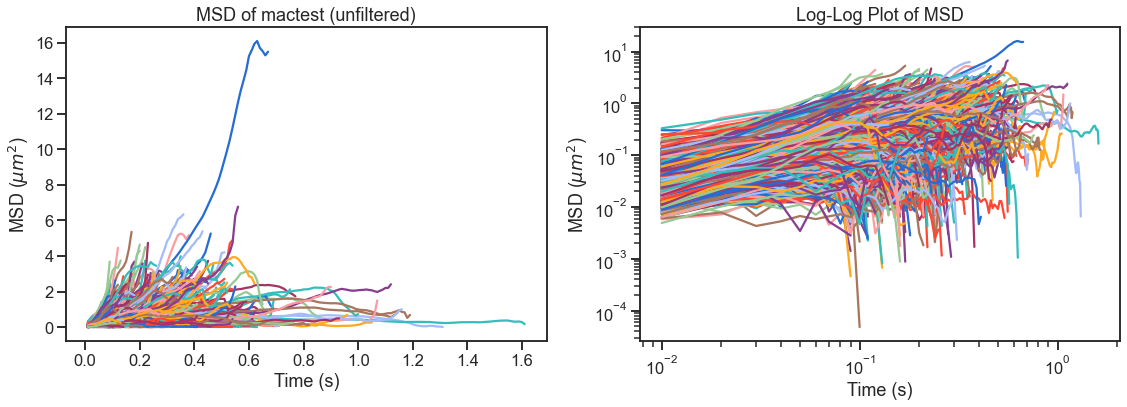

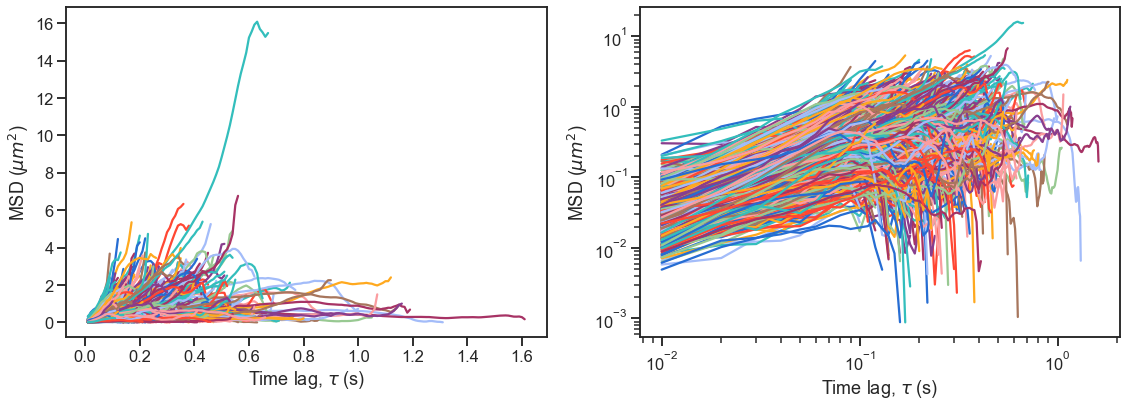

Median after filtering for MSD curve fit above R$^2$  0.8 :  0.7213894229670833


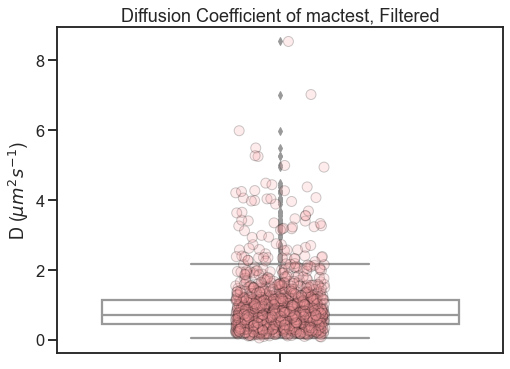

In [11]:
#####################################################
# Change the following inputs to match your dataset #
#####################################################
dir = '/Users/bissonlab/Desktop/Katie/'
folder1 = 'TrackData/'
#folder2 = 'Rep 2 bBL116/tracks in cells/'

sample_id1 = 'mactest'
#sample_id2 = 'NBWT-rep1.2'

min_lifetime = 10 # frames
time_per_frame = 0.01 # seconds
min_disp = 0 # micron

#################################################################################################
# Run the functions import_data and graphs here on one folder containing your desired condition #
#################################################################################################
#Filter out tracks with R2 below 0.8 
test1 = import_data(dir, folder1, sample_id1, min_lifetime, time_per_frame, min_disp)                  
graphs(test1, sample_id1, min_lifetime, time_per_frame, 0.8)

#test2 = import_data(dir, folder2, sample_id2, min_lifetime, time_per_frame, min_disp)                 
#graphs(test2, sample_id2, min_lifetime, time_per_frame, 0.8)
